In [1]:
%matplotlib inline
import math
import numpy as np
import scipy
from numpy import random
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style('white')

# Privacy guarantees under model mismatch

Given a bound $\bar{P}$ on the maximum persistence of any individual $x \in \mathcal{X}$ in the video, for a target $\epsilon$ the noise added for an average/mean query is drawn from the Laplace distribuion with the following density:

$$p(\eta) = \frac{\epsilon}{2 \Delta} e^{-\frac{\epsilon}{\Delta}\eta}$$.

Here the sensitivity is

$$\Delta = \frac{u - \ell}{w} \bar{P}$$,

where $u$ and $\ell$ are upper and lower bounds on the query value for a block and $w$ is the number of blocks in the window. Let us take $u = 1$ and $\ell = 0$ for simplicity so that the sensitivity is

$$\Delta(\bar{P}) = \frac{\bar{P}}{w}$$

Turning this around, if the density of the Laplace distribution is

$$p(\eta) = \frac{1}{2 \alpha} \exp\left( - \eta/\alpha \right)$$,

then we set $\alpha = \frac{\Delta(\bar{P})}{\epsilon}$ to guarantee $\epsilon$-differntial privacy when the sensitivity is $\Delta(\bar{P})$ then if we add this noise to a query when the true persistence of an individual is $P$, we can ask what privacy risk $\epsilon(P)$ adding this noise will have:

$$\frac{\Delta(\bar{P})}{\epsilon} = \alpha = \frac{\Delta(P)}{\epsilon(P)}$$.

Solving for $\epsilon(P)$ we see

$$\epsilon{P} = \frac{ \Delta(P) }{ \Delta(\bar{P}) } \epsilon = \frac{P}{\bar{P}} \epsilon$$.

Suppose an individual $x \in \mathcal{X}$ persists in the video for a duration longer than the assumed $\bar{P}$.

### Translating differential privacy into detection probability

Let us consider a binary hypothesis testing problem from the point of view of an adversary who can see the noisy response $\hat{q} = \mathbf{Q}(W) + \eta$ from the system. The two hypotheses are as follows:

$$\mathcal{H}_0: \textrm{individual $x$ does not appear in $W$}$$
$$\mathcal{H}_1: \textrm{individual $x$ appears in $W$}$$

A test $T$ maps $\hat{q}$ to a decision, $0$ or $1$. The false alarm $P_{\mathrm{FA}}$ and miss detection $P_{\mathrm{FA}}$ probabilities are

$$P_{\mathrm{FA}} = \mathbb{P}( T(\hat{q}) = 1 ~|~ \mathcal{H}_0 )$$
$$P_{\mathrm{MD}} = \mathbb{P}( T(\hat{q}) = 0 ~|~ \mathcal{H}_1 )$$

From the results of Wasserman and Zhou (see also Kairouz et al.), if an algorithm guarantees $(\epsilon,\delta)$-differential privacy then the probability of false alarm and miss detection for *any test* using $\hat{q]$ are related as follows:

$$P_{\mathrm{FA}} + e^{\epsilon} P_{\mathrm{MD}} \ge 1 - \delta$$
$$P_{\mathrm{MD}} + e^{\epsilon} P_{\mathrm{FA}} \ge 1 - \delta$$

If we restrict attention to $\epsilon$-differential privacy we get

$$P_{\mathrm{FA}} + e^{\epsilon} P_{\mathrm{MD}} \ge 1$$
$$P_{\mathrm{MD}} + e^{\epsilon} P_{\mathrm{FA}} \ge 1$$

Suppose we fix $P_{\mathrm{FA}} \le \beta$ for some target $\beta$. What is the lowest $P_{\mathrm{MD}}$ we can get? This would correspond to saying that the adversary is trying to maximize their chance of correctly identifying $x$ if they *are present* in the video while making sure that if $x$ is *not present* then the chance they say $x$ is present would be at most $\beta$. So if $\beta = 0.1$ then subject to claiming $x$ is in the video when they are not with probability at most 10%, what is the maximum probability of claiming $x$ is in the video when they are present?

Manipulating the bounds a bit, we see

$$1 - P_{\mathrm{MD}} \le e^{\epsilon} P_{\mathrm{FA}} \le e^{\epsilon} \beta$$

and

$$1 - P_{\mathrm{MD}} \le e^{-\epsilon} (P_{\mathrm{FA}} - (1 - e^{\epsilon})) \le e^{-\epsilon} (\beta - (1 - e^{\epsilon}))$$

So the probability of correctly detecting that $x$ is present in the video is

$$\mathbb{P}( T(\hat{q}) = 1 ~|~ \mathcal{H}_1 ) \le \min\{ e^{\epsilon} \beta, e^{-\epsilon} (\beta - (1 - e^{\epsilon})) \}$$.

We can visualize this.

Text(0.5, 0, 'privacy risk $\\epsilon$')

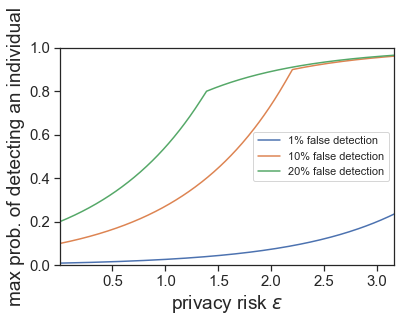

In [4]:
# Best probability of error for given P_FA

epsilons = np.logspace(-3.0,0.5,1000)

def PDbound(epsilon,beta):
    t1 = np.exp(epsilon) * beta
    t2 = np.exp(-epsilon)*(beta - (1 - np.exp(epsilon)))
    return min(t1,t2)
PDbound = np.vectorize(PDbound)


xmin = min(epsilons)
xmax = max(epsilons)
ymin = 0.0
ymax = 1.0
fig_pd = plt.figure()
ax = fig_pd.add_subplot(111)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
pfa1, = plt.plot(epsilons,PDbound(epsilons,0.01))
pfa10, = plt.plot(epsilons,PDbound(epsilons,0.1))
pfa20, = plt.plot(epsilons,PDbound(epsilons,0.2))

plt.legend(handles=[pfa1,pfa10,pfa20],labels = ['1% false detection','10% false detection','20% false detection'])
plt.ylabel('max prob. of detecting an individual')
plt.xlabel(r"privacy risk $\epsilon$")
#plt.savefig('img/DetectionVsEpsilon.pdf',bbox_inches='tight')


Now let us consider the case of excess persistence over $\bar{P}$. From the argument above we can see that if the true $P = (1 + \gamma) \bar{P}$ then the effective privacy risk is $(1 + \gamma) \epsilon$. Armed with this we can plot the bound on the probability of correct detection of $x$ as a function of the excess persistence $x$ has in the video.

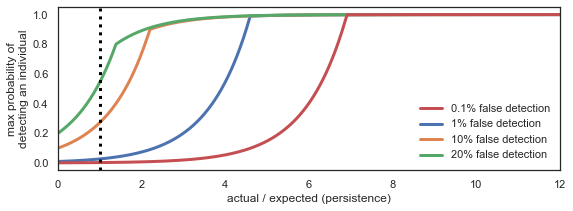

In [3]:
#plt.figure(figsize=(9,3))

#sns.set_context("paper", font_scale=2)
sns.set_style("white")

epsilon_nominal = 1
excess_persistence = np.linspace(0.0,12.0,100000)
epsilon_effective = epsilon_nominal * excess_persistence

fig_excess = plt.figure(figsize=(9,3))
ax = fig_excess.add_subplot(111)
pfa1, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.01), linewidth=3)
pfa10, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.1), linewidth=3)
pfa20, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.2), linewidth=3)
pfa0, = plt.plot(excess_persistence, PDbound(epsilon_effective,0.001), linewidth=3)


plt.legend(loc='lower right', handles=[pfa0, pfa1,pfa10,pfa20],labels = ['0.1% false detection','1% false detection','10% false detection','20% false detection'], frameon=False)#, fontsize=11)

plt.ylabel('max probability of\ndetecting an individual')#, fontsize=12)
plt.xlabel("actual / expected (persistence)")#, fontsize=12)
#plt.yticks(fontsize=12)
#plt.xticks(range(0,10), fontsize=12)
ax.set_xlim([0,12])
plt.axvline(1, color='black', linestyle='dotted', linewidth=3)
plt.savefig('../img/degrade.pdf',bbox_inches='tight')


<Figure size 648x216 with 0 Axes>

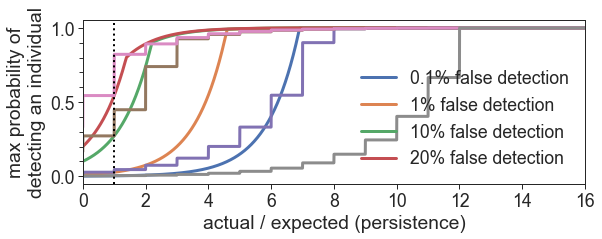

In [61]:
plt.figure(figsize=(9,3))
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def VaryP(rel,beta):
    c = 30 # seconds
    p = 30
    phat = p * rel

    k = 1
    khat = 1
    # khat = rel * k
    # epsilon = (khat / k)
    
    epsilon = (khat * (1 + np.ceil(phat/c))) / (k * (1 + np.ceil(p/c)))

    
    t1 = np.exp(epsilon) * beta
    t2 = np.exp(-epsilon)*(beta - (1 - np.exp(epsilon)))
    return min(t1,t2)
VaryP = np.vectorize(VaryP)

#sns.set_context("paper", font_scale=2)
sns.set_style("ticks")

epsilon_nominal = 1
excess_persistence = np.linspace(0.0,16.0,100000)
epsilon_effective = epsilon_nominal * excess_persistence

alphas = [0.001, 0.01, 0.1, 0.2]

fig_excess = plt.figure(figsize=(9,3))
ax = fig_excess.add_subplot(111)
pfa0, = plt.plot(excess_persistence, PDbound(epsilon_effective,0.001), linewidth=3)
pfa1, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.01), linewidth=3)
pfa10, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.1), linewidth=3)
pfa20, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.2), linewidth=3)
plt.plot(excess_persistence,VaryP(epsilon_effective,0.01), linewidth=3)
plt.plot(excess_persistence,VaryP(epsilon_effective,0.1), linewidth=3)
plt.plot(excess_persistence,VaryP(epsilon_effective,0.2), linewidth=3)
plt.plot(excess_persistence, VaryP(epsilon_effective,0.001), linewidth=3)

plt.legend(loc='lower right', handles=[pfa0, pfa1,pfa10,pfa20],labels = ['0.1% false detection','1% false detection','10% false detection','20% false detection'], frameon=False)#, fontsize=11)

plt.ylabel('max probability of\ndetecting an individual')#, fontsize=12)
plt.xlabel("actual / expected (persistence)")#, fontsize=12)
#plt.yticks(fontsize=12)
#plt.xticks(range(0,10), fontsize=12)
ax.set_xlim([0,16])
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=4, color='black')
for (i,alpha) in enumerate(alphas):
    inflection = np.log((1-alpha)/alpha)
    max_prob = np.exp(inflection) * alpha
    #ax.hlines(y=max_prob, xmax=inflection, xmin=0, colors=[f"C{i}"], linestyles='dashed')
    #ax.vlines(x=inflection, ymin=0, ymax=max_prob, colors=[f"C{i}"], linestyles='dashed')
plt.axvline(1, color='black', linestyle='dotted', linewidth=2)
plt.savefig('../img/degrade.pdf',bbox_inches='tight')


In [ ]:
# FYI: inflection point is roughly ln((1 - alpha) / alpha)
# TODO make a graph with line from axes to inflection point for each line to show where it's hitting (OR a colored notch on the x and y axes)
# TODO make graph aesthetic match recent 5g graphs

In [2]:
import matplotlib as mpl


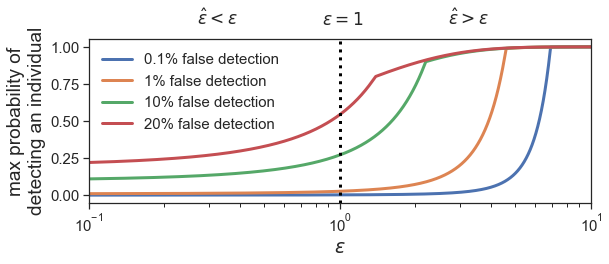

In [17]:
#plt.figure(figsize=(9,3))

#sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.labelsize'] = 19
mpl.rcParams['text.usetex'] = False

epsilon_nominal = 1
excess_persistence = np.logspace(-1,1.0,10000)
epsilon_effective = epsilon_nominal * excess_persistence

fig_excess = plt.figure(figsize=(9,3))
ax = fig_excess.add_subplot(111)
pfa0, = plt.plot(excess_persistence, PDbound(epsilon_effective,0.001), linewidth=3)
pfa1, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.01), linewidth=3)
pfa10, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.1), linewidth=3)
pfa20, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.2), linewidth=3)


plt.legend(loc='upper left', handles=[pfa0, pfa1,pfa10,pfa20],labels = ['0.1% false detection','1% false detection','10% false detection','20% false detection'], frameon=False, fontsize=15)

plt.ylabel('max probability of\ndetecting an individual')#, fontsize=12)
plt.xlabel(r'$\epsilon$')#, fontsize=12)
#plt.yticks(fontsize=12)
#plt.xticks(range(0,10), fontsize=12)
ax.set_xlim([0.1,10])
ax.set_xscale('log')
ax.annotate(r'$\hat{\epsilon} < \epsilon$', xy=(0.27, 1.15), xycoords='data', annotation_clip=False, fontsize=17)
ax.annotate(r'$\hat{\epsilon} > \epsilon$', xy=(2.7, 1.15), xycoords='data', annotation_clip=False, fontsize=17)
ax.annotate(r'$\epsilon=1$', xy=(0.85, 1.15), xycoords='data', annotation_clip=False, fontsize=17)

plt.axvline(1, color='black', linestyle='dotted', linewidth=3)
plt.savefig('../img/degrade.pdf',bbox_inches='tight')


/var/folders/4t/f6b68p1n6817rq7v5nzy2jnw0000gp/T/ipykernel_48506/2894804085.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', r'$\frac{1}{10}$','1', '10x'])


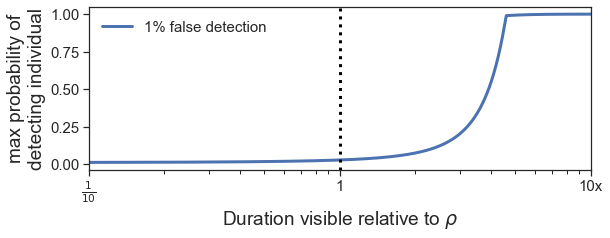

In [15]:
#plt.figure(figsize=(9,3))

#sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.labelsize'] = 19
mpl.rcParams['text.usetex'] = False

epsilon_nominal = 1
excess_persistence = np.logspace(-1,1.0,10000)
epsilon_effective = epsilon_nominal * excess_persistence

fig_excess = plt.figure(figsize=(9,3))
ax = fig_excess.add_subplot(111)
#pfa0, = plt.plot(excess_persistence, PDbound(epsilon_effective,0.001), linewidth=3)
pfa1, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.01), linewidth=3)
#pfa10, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.1), linewidth=3)
#pfa20, = plt.plot(excess_persistence,PDbound(epsilon_effective,0.2), linewidth=3)


plt.legend(loc='upper left', handles=[pfa0, pfa1,pfa10,pfa20],labels = ['1% false detection'], frameon=False, fontsize=15)

plt.ylabel('max probability of\ndetecting individual')#, fontsize=12)
plt.xlabel(r'Duration visible relative to $\rho$')#, fontsize=12)
#plt.yticks(fontsize=12)
#plt.xticks(range(0,10), fontsize=12)
ax.set_xlim([0.1,10])
ax.set_xscale('log')
ax.set_xticklabels(['', r'$\frac{1}{10}$','1', '10x'])
#ax.annotate(r'$\hat{\epsilon} < \epsilon$', xy=(0.27, 1.15), xycoords='data', annotation_clip=False, fontsize=17)
#ax.annotate(r'$\hat{\epsilon} > \epsilon$', xy=(2.7, 1.15), xycoords='data', annotation_clip=False, fontsize=17)
#ax.annotate(r'$\epsilon=1$', xy=(0.85, 1.15), xycoords='data', annotation_clip=False, fontsize=17)

plt.axvline(1, color='black', linestyle='dotted', linewidth=3)
plt.savefig('../img/degrade.pdf',bbox_inches='tight')
